In [1]:
import numpy as np
import pandas as pd

# Torch
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, recall_score

In [2]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
df_inputs = torch.load('tensors/df_inputs.pt')
df_inputs

tensor([[4.5576e-05, 3.0794e-04, 1.3047e-04,  ..., 6.7453e-04, 1.7936e-04,
         2.9505e-04],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.2047e-05, 5.0618e-04, 1.4842e-04,  ..., 9.8053e-04, 2.2889e-04,
         3.1280e-04],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.2441e-05, 2.8238e-04, 8.2643e-05,  ..., 6.1632e-04, 1.5307e-04,
         1.9238e-04]])

In [4]:
df_targets = torch.load('tensors/df_targets.pt')
df_targets

tensor([0, 1, 0,  ..., 1, 0, 0])

In [5]:
X_test_vec = torch.load('tensors/X_test_vec.pt')
X_test_vec

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [6]:
y_test = torch.load('tensors/y_test.pt')
y_test

tensor([1, 2, 2,  ..., 1, 2, 1])

In [7]:
NUM_CLASSES = 3
NUM_FEATURES = 5000

class BalancedNeuralNetwork(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.hidden_layer_1 = nn.Linear(self.in_dim, 50) # input to first hidden layer, produces 50 features
        self.output_layer = nn.Linear(50, self.out_dim) # takes in 50 features, produces 3 feature (y)
        self.dropout = nn.Dropout(p=0.7)
        self.activation = nn.ReLU()  # <- add in ReLU activation function

    def forward(self, x):
        x = self.dropout(self.activation(self.hidden_layer_1(x)))
        y = self.output_layer(x)
        
        return y

In [8]:
# Create an instance of the model and send it to target device
model_2 = BalancedNeuralNetwork(in_dim=NUM_FEATURES, out_dim=NUM_CLASSES).to(device)
model_2

BalancedNeuralNetwork(
  (hidden_layer_1): Linear(in_features=5000, out_features=50, bias=True)
  (output_layer): Linear(in_features=50, out_features=3, bias=True)
  (dropout): Dropout(p=0.7, inplace=False)
  (activation): ReLU()
)

In [9]:
learning_rate_2 = 0.0001
loss_fn_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.Adam(model_2.parameters(), lr=learning_rate_2)
batch_size = 128

In [10]:
# Custom dataset to treat how the model picks an x, y combination from the dataset
class MyCustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [11]:
# Define the training process
# Each call of the train function == 1 Epoch
import time
def train_fn(loader, model, optimizer, loss_fn, batch_size):
    loop = tqdm(loader)
    
    count = 0
    ave_loss = 0.00
    
    # Loop per batch
    for batch_idx, (features, targets) in enumerate(loop):
        y_logits = model.forward(features)

        # Calculate loss
        loss = loss_fn(y_logits, targets)
        
        # Optimizer zero grad
        optimizer.zero_grad()
        
        # Loss backwards
        loss.backward()
        
        # Optimizer Step
        optimizer.step()
        
        loop.set_postfix(loss=loss.item())
        
        ave_loss += loss.item()
        count += 1
        
    ave_loss = ave_loss / count
    
    return ave_loss

# Dataloader is in charge of:
# - partitioning data into batches
# - optionally shuffling the data
# - run the optimizer against a partition defined by this loader
custom_dataset_2 = MyCustomDataset(x=df_inputs, y=df_targets)

train_loader = DataLoader(
    custom_dataset_2,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

epochs = 100
losses_2 = []

start = time.time()
for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    ave_loss = train_fn(
        train_loader,
        model_2,
        optimizer_2,
        loss_fn_2,
        batch_size
    )
    
    losses_2.append(ave_loss)
    
    print("Ave Loss: {}".format(ave_loss))

end = time.time()    
print(f'Training duration: {(end-start)} seconds')

state = { 'state_dict': model_2.state_dict() }
torch.save(state, "./torch_models/model_2.pth")

Epoch: 0


100%|██████████| 492/492 [00:08<00:00, 58.09it/s, loss=1.08]


Ave Loss: 1.0903565416006538
Epoch: 1


100%|██████████| 492/492 [00:07<00:00, 69.91it/s, loss=1.02] 


Ave Loss: 1.0466781635352267
Epoch: 2


100%|██████████| 492/492 [00:06<00:00, 70.93it/s, loss=0.926]


Ave Loss: 0.9805019304035155
Epoch: 3


100%|██████████| 492/492 [00:06<00:00, 72.05it/s, loss=0.868]


Ave Loss: 0.9165418710165877
Epoch: 4


100%|██████████| 492/492 [00:07<00:00, 69.19it/s, loss=0.781]


Ave Loss: 0.8638088752826055
Epoch: 5


100%|██████████| 492/492 [00:07<00:00, 69.63it/s, loss=0.761]


Ave Loss: 0.8259723770424603
Epoch: 6


100%|██████████| 492/492 [00:07<00:00, 69.30it/s, loss=0.729]


Ave Loss: 0.7953071763844994
Epoch: 7


100%|██████████| 492/492 [00:06<00:00, 72.34it/s, loss=0.747]


Ave Loss: 0.7703779751692361
Epoch: 8


100%|██████████| 492/492 [00:06<00:00, 72.80it/s, loss=0.66] 


Ave Loss: 0.7491295351003243
Epoch: 9


100%|██████████| 492/492 [00:06<00:00, 73.33it/s, loss=0.654]


Ave Loss: 0.7326513824424123
Epoch: 10


100%|██████████| 492/492 [00:06<00:00, 72.04it/s, loss=0.66] 


Ave Loss: 0.7175326228626375
Epoch: 11


100%|██████████| 492/492 [00:06<00:00, 73.07it/s, loss=0.616]


Ave Loss: 0.7058492729334327
Epoch: 12


100%|██████████| 492/492 [00:06<00:00, 72.82it/s, loss=0.648]


Ave Loss: 0.6958304344396281
Epoch: 13


100%|██████████| 492/492 [00:06<00:00, 73.68it/s, loss=0.557]


Ave Loss: 0.6858646572847676
Epoch: 14


100%|██████████| 492/492 [00:06<00:00, 73.83it/s, loss=0.627]


Ave Loss: 0.6796744584552641
Epoch: 15


100%|██████████| 492/492 [00:06<00:00, 73.63it/s, loss=0.567]


Ave Loss: 0.6700019133769399
Epoch: 16


100%|██████████| 492/492 [00:06<00:00, 74.21it/s, loss=0.556]


Ave Loss: 0.6649949520341749
Epoch: 17


100%|██████████| 492/492 [00:06<00:00, 73.80it/s, loss=0.595]


Ave Loss: 0.6601233863975944
Epoch: 18


100%|██████████| 492/492 [00:06<00:00, 72.99it/s, loss=0.576]


Ave Loss: 0.6525029198425573
Epoch: 19


100%|██████████| 492/492 [00:06<00:00, 72.88it/s, loss=0.502]


Ave Loss: 0.6476225991074632
Epoch: 20


100%|██████████| 492/492 [00:06<00:00, 73.31it/s, loss=0.577]


Ave Loss: 0.6415408594700379
Epoch: 21


100%|██████████| 492/492 [00:06<00:00, 74.50it/s, loss=0.534]


Ave Loss: 0.6405512846824599
Epoch: 22


100%|██████████| 492/492 [00:06<00:00, 73.76it/s, loss=0.554]


Ave Loss: 0.6369634026555511
Epoch: 23


100%|██████████| 492/492 [00:06<00:00, 74.68it/s, loss=0.47] 


Ave Loss: 0.6309294188773729
Epoch: 24


100%|██████████| 492/492 [00:06<00:00, 73.69it/s, loss=0.628]


Ave Loss: 0.6273689456586915
Epoch: 25


100%|██████████| 492/492 [00:06<00:00, 74.12it/s, loss=0.522]


Ave Loss: 0.6221834566535019
Epoch: 26


100%|██████████| 492/492 [00:06<00:00, 74.52it/s, loss=0.575]


Ave Loss: 0.6226673425455403
Epoch: 27


100%|██████████| 492/492 [00:06<00:00, 73.82it/s, loss=0.537]


Ave Loss: 0.6198950669750934
Epoch: 28


100%|██████████| 492/492 [00:06<00:00, 74.41it/s, loss=0.519]


Ave Loss: 0.6163847283498058
Epoch: 29


100%|██████████| 492/492 [00:06<00:00, 73.24it/s, loss=0.559]


Ave Loss: 0.6126625008457075
Epoch: 30


100%|██████████| 492/492 [00:06<00:00, 73.84it/s, loss=0.462]


Ave Loss: 0.6111927463756344
Epoch: 31


100%|██████████| 492/492 [00:06<00:00, 73.78it/s, loss=0.471]


Ave Loss: 0.6064244839476376
Epoch: 32


100%|██████████| 492/492 [00:06<00:00, 74.22it/s, loss=0.456]


Ave Loss: 0.6048177038508702
Epoch: 33


100%|██████████| 492/492 [00:06<00:00, 74.45it/s, loss=0.452]


Ave Loss: 0.6035426866596307
Epoch: 34


100%|██████████| 492/492 [00:06<00:00, 74.16it/s, loss=0.475]


Ave Loss: 0.6033990799896116
Epoch: 35


100%|██████████| 492/492 [00:06<00:00, 74.30it/s, loss=0.519]


Ave Loss: 0.5987952914906711
Epoch: 36


100%|██████████| 492/492 [00:06<00:00, 74.40it/s, loss=0.473]


Ave Loss: 0.5944675374321822
Epoch: 37


100%|██████████| 492/492 [00:06<00:00, 73.77it/s, loss=0.464]


Ave Loss: 0.5928713547868457
Epoch: 38


100%|██████████| 492/492 [00:06<00:00, 74.29it/s, loss=0.463]


Ave Loss: 0.5926945692276567
Epoch: 39


100%|██████████| 492/492 [00:06<00:00, 73.82it/s, loss=0.516]


Ave Loss: 0.5926123515861791
Epoch: 40


100%|██████████| 492/492 [00:07<00:00, 69.41it/s, loss=0.453]


Ave Loss: 0.5947994455331709
Epoch: 41


100%|██████████| 492/492 [00:07<00:00, 67.83it/s, loss=0.487]


Ave Loss: 0.5854381370108303
Epoch: 42


100%|██████████| 492/492 [00:06<00:00, 73.71it/s, loss=0.44] 


Ave Loss: 0.584023537492849
Epoch: 43


100%|██████████| 492/492 [00:06<00:00, 74.14it/s, loss=0.434]


Ave Loss: 0.5820991283630937
Epoch: 44


100%|██████████| 492/492 [00:06<00:00, 74.04it/s, loss=0.456]


Ave Loss: 0.5826070309896779
Epoch: 45


100%|██████████| 492/492 [00:06<00:00, 74.20it/s, loss=0.446]


Ave Loss: 0.5799194410201011
Epoch: 46


100%|██████████| 492/492 [00:06<00:00, 71.31it/s, loss=0.529]


Ave Loss: 0.5789090938320974
Epoch: 47


100%|██████████| 492/492 [00:06<00:00, 73.58it/s, loss=0.474]


Ave Loss: 0.5761822742538724
Epoch: 48


100%|██████████| 492/492 [00:06<00:00, 77.09it/s, loss=0.405]


Ave Loss: 0.5747903023914593
Epoch: 49


100%|██████████| 492/492 [00:06<00:00, 78.98it/s, loss=0.472]


Ave Loss: 0.5734044880401797
Epoch: 50


100%|██████████| 492/492 [00:06<00:00, 81.89it/s, loss=0.417]


Ave Loss: 0.5714758434067897
Epoch: 51


100%|██████████| 492/492 [00:06<00:00, 80.06it/s, loss=0.422]


Ave Loss: 0.5695755749456282
Epoch: 52


100%|██████████| 492/492 [00:06<00:00, 81.10it/s, loss=0.461]


Ave Loss: 0.5665091420334529
Epoch: 53


100%|██████████| 492/492 [00:06<00:00, 80.86it/s, loss=0.383]


Ave Loss: 0.5665499767273422
Epoch: 54


100%|██████████| 492/492 [00:06<00:00, 81.23it/s, loss=0.444]


Ave Loss: 0.5673687514977727
Epoch: 55


100%|██████████| 492/492 [00:06<00:00, 79.73it/s, loss=0.407]


Ave Loss: 0.564797736522628
Epoch: 56


100%|██████████| 492/492 [00:06<00:00, 78.72it/s, loss=0.453]


Ave Loss: 0.5643429780394081
Epoch: 57


100%|██████████| 492/492 [00:06<00:00, 80.39it/s, loss=0.4]  


Ave Loss: 0.5617990871755089
Epoch: 58


100%|██████████| 492/492 [00:06<00:00, 81.27it/s, loss=0.41] 


Ave Loss: 0.5592671139090042
Epoch: 59


100%|██████████| 492/492 [00:06<00:00, 80.38it/s, loss=0.384]


Ave Loss: 0.560689342034057
Epoch: 60


100%|██████████| 492/492 [00:06<00:00, 81.08it/s, loss=0.362]


Ave Loss: 0.5574762798785194
Epoch: 61


100%|██████████| 492/492 [00:06<00:00, 80.29it/s, loss=0.395]


Ave Loss: 0.5550935562790894
Epoch: 62


100%|██████████| 492/492 [00:06<00:00, 81.18it/s, loss=0.409]


Ave Loss: 0.5563992598677069
Epoch: 63


100%|██████████| 492/492 [00:06<00:00, 80.79it/s, loss=0.358]


Ave Loss: 0.5552682014621371
Epoch: 64


100%|██████████| 492/492 [00:06<00:00, 80.86it/s, loss=0.403]


Ave Loss: 0.5534009857148658
Epoch: 65


100%|██████████| 492/492 [00:06<00:00, 80.43it/s, loss=0.357]


Ave Loss: 0.5533342673405399
Epoch: 66


100%|██████████| 492/492 [00:06<00:00, 80.79it/s, loss=0.387]


Ave Loss: 0.549818593736102
Epoch: 67


100%|██████████| 492/492 [00:06<00:00, 80.02it/s, loss=0.405]


Ave Loss: 0.5501527059368971
Epoch: 68


100%|██████████| 492/492 [00:06<00:00, 81.72it/s, loss=0.459]


Ave Loss: 0.5502487378634089
Epoch: 69


100%|██████████| 492/492 [00:06<00:00, 79.41it/s, loss=0.369]


Ave Loss: 0.548010403123813
Epoch: 70


100%|██████████| 492/492 [00:06<00:00, 80.81it/s, loss=0.382]


Ave Loss: 0.5463532200310288
Epoch: 71


100%|██████████| 492/492 [00:06<00:00, 79.72it/s, loss=0.331]


Ave Loss: 0.5442204126497594
Epoch: 72


100%|██████████| 492/492 [00:06<00:00, 81.28it/s, loss=0.374]


Ave Loss: 0.5436224066993085
Epoch: 73


100%|██████████| 492/492 [00:06<00:00, 80.59it/s, loss=0.343]


Ave Loss: 0.5445472446035563
Epoch: 74


100%|██████████| 492/492 [00:06<00:00, 80.98it/s, loss=0.349]


Ave Loss: 0.5394704990634104
Epoch: 75


100%|██████████| 492/492 [00:06<00:00, 80.76it/s, loss=0.402]


Ave Loss: 0.5384551572000108
Epoch: 76


100%|██████████| 492/492 [00:06<00:00, 79.90it/s, loss=0.343]


Ave Loss: 0.5385133083152577
Epoch: 77


100%|██████████| 492/492 [00:06<00:00, 81.04it/s, loss=0.349]


Ave Loss: 0.5369664535411005
Epoch: 78


100%|██████████| 492/492 [00:06<00:00, 80.84it/s, loss=0.45] 


Ave Loss: 0.5381851968605343
Epoch: 79


100%|██████████| 492/492 [00:06<00:00, 80.55it/s, loss=0.359]


Ave Loss: 0.5338627185399939
Epoch: 80


100%|██████████| 492/492 [00:06<00:00, 79.96it/s, loss=0.411]


Ave Loss: 0.535101551108244
Epoch: 81


100%|██████████| 492/492 [00:06<00:00, 80.73it/s, loss=0.381]


Ave Loss: 0.5355939896610694
Epoch: 82


100%|██████████| 492/492 [00:06<00:00, 79.82it/s, loss=0.395]


Ave Loss: 0.5323585454162544
Epoch: 83


100%|██████████| 492/492 [00:06<00:00, 80.62it/s, loss=0.4]  


Ave Loss: 0.5291856379528356
Epoch: 84


100%|██████████| 492/492 [00:06<00:00, 80.55it/s, loss=0.389]


Ave Loss: 0.5312171994549472
Epoch: 85


100%|██████████| 492/492 [00:06<00:00, 81.97it/s, loss=0.405]


Ave Loss: 0.5276070672685538
Epoch: 86


100%|██████████| 492/492 [00:06<00:00, 79.25it/s, loss=0.382]


Ave Loss: 0.5270078276715627
Epoch: 87


100%|██████████| 492/492 [00:06<00:00, 80.30it/s, loss=0.367]


Ave Loss: 0.5291766140276823
Epoch: 88


100%|██████████| 492/492 [00:06<00:00, 79.50it/s, loss=0.414]


Ave Loss: 0.5255888925214124
Epoch: 89


100%|██████████| 492/492 [00:06<00:00, 80.62it/s, loss=0.418]


Ave Loss: 0.5248077436070132
Epoch: 90


100%|██████████| 492/492 [00:06<00:00, 79.41it/s, loss=0.376]


Ave Loss: 0.5263569365308537
Epoch: 91


100%|██████████| 492/492 [00:06<00:00, 80.01it/s, loss=0.364]


Ave Loss: 0.5229281021085211
Epoch: 92


100%|██████████| 492/492 [00:06<00:00, 79.42it/s, loss=0.399]


Ave Loss: 0.5203688306415953
Epoch: 93


100%|██████████| 492/492 [00:06<00:00, 80.24it/s, loss=0.335]


Ave Loss: 0.5214507949909544
Epoch: 94


100%|██████████| 492/492 [00:06<00:00, 79.48it/s, loss=0.353]


Ave Loss: 0.52160354485599
Epoch: 95


100%|██████████| 492/492 [00:06<00:00, 80.61it/s, loss=0.444]


Ave Loss: 0.520218076684126
Epoch: 96


100%|██████████| 492/492 [00:06<00:00, 80.10it/s, loss=0.377]


Ave Loss: 0.5184959490003624
Epoch: 97


100%|██████████| 492/492 [00:06<00:00, 79.74it/s, loss=0.35] 


Ave Loss: 0.5168698696586175
Epoch: 98


100%|██████████| 492/492 [00:06<00:00, 79.75it/s, loss=0.335]


Ave Loss: 0.5181827892859777
Epoch: 99


100%|██████████| 492/492 [00:06<00:00, 80.12it/s, loss=0.384]


Ave Loss: 0.517875824456777
Training duration: 644.2183227539062 seconds


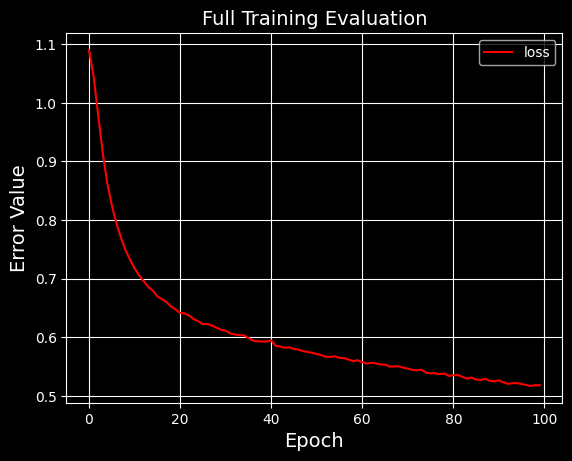

In [12]:
plt.plot(losses_2, label='loss', color='red')
plt.title('Full Training Evaluation', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Error Value', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

In [13]:
model_2 = BalancedNeuralNetwork(5000,3)
state = torch.load("./torch_models/model_2.pth")
model_2.load_state_dict(state['state_dict'])

<All keys matched successfully>

In [14]:
predictions_2 = model_2.forward(X_test_vec)
predictions_2 = torch.softmax(predictions_2, dim=1)
predictions_2 = torch.argmax(predictions_2, dim=1)
predictions_2

tensor([1, 1, 1,  ..., 1, 1, 0])

In [15]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predictions_2)
accuracy

0.4093608454957222

In [16]:
from sklearn.metrics import recall_score

recall = recall_score(y_test, predictions_2, average='macro')
recall

0.3887423017692065

In [17]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions_2))

              precision    recall  f1-score   support

           0       0.21      0.34      0.26      1550
           1       0.48      0.54      0.51      4451
           2       0.47      0.29      0.36      3934

    accuracy                           0.41      9935
   macro avg       0.39      0.39      0.37      9935
weighted avg       0.43      0.41      0.41      9935

